In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_functions import lin_pix2ang, get_calib_params

In [7]:
base_locations = {
                'O':(0,0),
                'Ax':(5,0), 'Bx':(10,0), 'Cx':(15,0), 'Dx':(20,0), 
                'Ay':(0,5), 'By':(0,10), 'Cy':(0,15), 'Dy':(0,20)
                 }

p_i_locations = {'p00': (5.03165194, 4.57002236),
                 'p01': (10.05731099, 4.18868622),
                 'p02': (15.05415693, 3.8242844),
                 'p03': None,
                 'p04': (15.59769377, 7.92667846),
                 'p05': (10.6052719 , 8.90105175),
                 'p06': None,
                 'p07': (5.4749749, 12.78020853),
                 'p08': (10.40416000, 19.3472800),
                 'p09': (10.74525086, 12.43331534),
                 'p10': (14.89773678, 13.35647657),
                 'p11': (18.40970773, 18.49790679)
                }

data_By = {'p00':(4131, 4172), 'p01':(3515, -1  ), 'p02':(3221, 3241),
           'p03':(3049, 3062), 'p04':(2613, 2647), 'p05':(2553, 2593),
           'p06':(2586, 2623), 'p07':(1249, 1274), 'p08':(700,  715 ),
           'p09':(1835, 1853), 'p10':(1848, 1859), 'p11':(1373, 1385), 'a':0
          }

data_Dx = {'p00':(960 , 966 ), 'p01':(1180, 1183), 'p02':(1757, 1748),
           'p03':(3706, 3693), 'p04':(2680, 2667), 'p05':(1988, 1974),
           'p06':(1556, 1547), 'p07':(1910, 1903), 'p08':(2764, 2752),
           'p09':(2379, 2368), 'p10':(2990, 2982), 'p11':(3601, 3595), 'a':135
          }

data_O =  {'p00':(3037, 3038), 'p01':(3791, 3791), 'p02':(4110, 4107),
           'p03':(4243, 4245), 'p04':(3617, 3613), 'p05':(3115, 3122),
           'p06':(2323, 2320), 'p07':(2065, 2052), 'p08':(2245, 2235),
           'p09':(2756, 2736), 'p10':(3037, 3032), 'p11':(2892, 2899), 'a':45
          }

data = {'By':data_By, 'Dx':data_Dx, 'O':data_O}

Calibration done by round 1


<IPython.core.display.Javascript object>


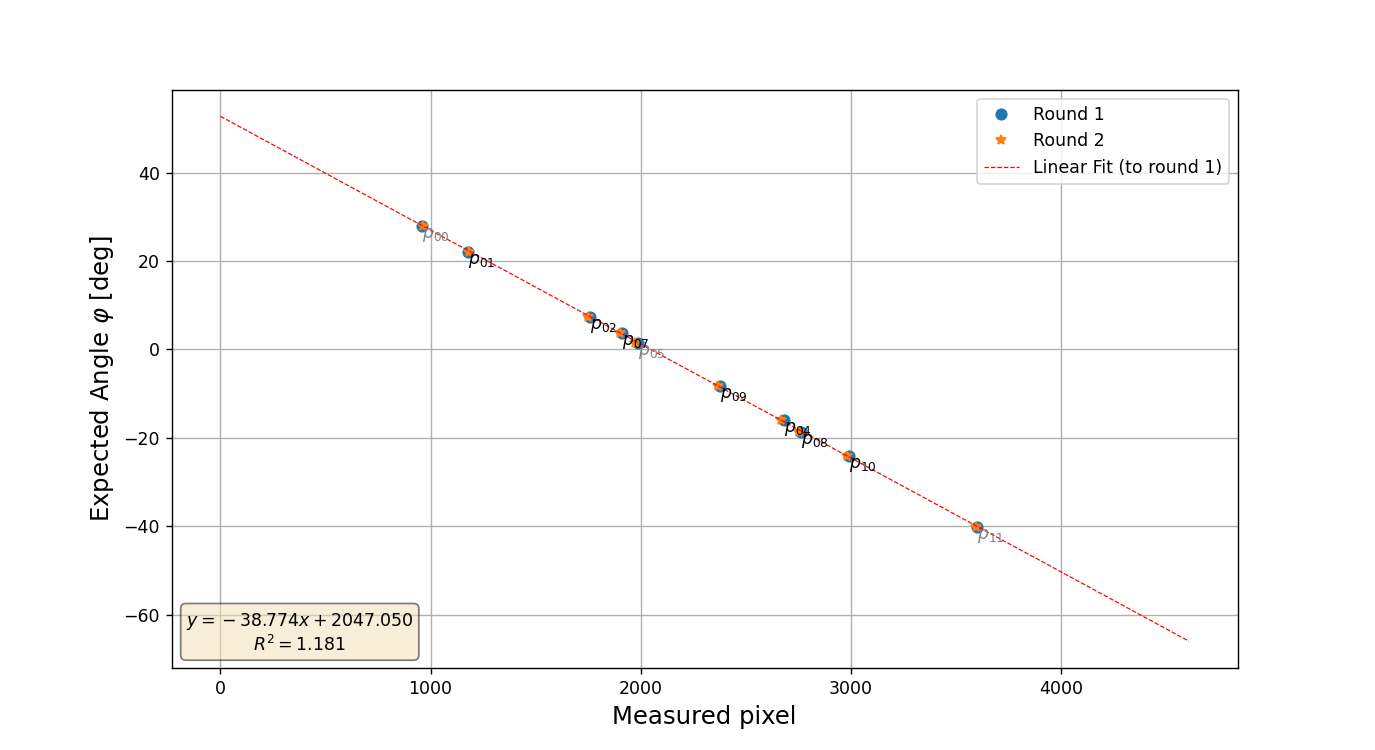

In [8]:
%matplotlib notebook
# %matplotlib inline

# Initialize the result array with nan values
result = np.zeros([4, len(p_i_locations)])  # first row -- expected values, second row -- measured values in pixels
result[:] = np.nan
# Populate the final row of the result array with indices
for i in range(result.shape[1]):
    result[-1, i] = i

cam = 'Dx'
cam_data = data[cam]
for i in range(result.shape[1]):  # Iterate over the points
    p = f'p{i:02d}'  # Format the point name as a string
    if p_i_locations[p] is None:  #  Skip the point if its location is not available
        continue
    # EXPECTED AZIMUTH:
    dx = p_i_locations[p][0] - base_locations[cam][0]  # Calculate the difference in x coordinates
    dy = p_i_locations[p][1] - base_locations[cam][1]  # Calculate the difference in y coordinates
    az = np.rad2deg(np.arctan2(dy, dx)) - cam_data['a']  # Calculate the azimuth angle
    result[0, i] = az  # Store the expected azimuth angle in the result array
    result[1, i] = cam_data[p][0]  # Store the measured 1st round in the result array
    result[2, i] = cam_data[p][1]  # Store the measured 2nd round in the result array
    
# Sort the result array by the expected azimuth angles
result = result[:, np.argsort(result[0,:])]

# Remove rows with nan values at the end of the result array
while all(np.isnan(result[:-1, -1])):
    result = result[:, :-1]

# Get the calibration parameters for the first round
m, b, R2, mask_non_calib = get_calib_params(result, 1)
    
# Create a figure and axes
fig, ax = plt.subplots(figsize=(11,6))

# Plot the calibrated angles for the first and second rounds against the expected azimuth angles
ax.plot(result[1, :][result[1, :]>=0], result[0,:][result[1, :]>=0], ls='None', marker='o', label='Round 1')
ax.plot(result[2, :][result[2, :]>=0], result[0,:][result[2, :]>=0], ls='None', marker='*', label='Round 2')
xVec = np.array([0, 4608])
ax.plot(xVec, (xVec-b)/m, color='red', ls='--', lw=.7, label='Linear Fit (to round 1)')  # Add a reference line

# Add labels to the points
for i in range(result.shape[1]):
    c = 'k'
    if (i == 0) or (i == result.shape[1]-1) or (i == result.shape[1]//2): #  paint gray points used for calibration
        c = 'gray'
    if not any(np.isnan(result[:2, i])):
        ax.text(result[1, i], result[0, i], r'$p_{'+f'{int(result[3,i]):02d}'+r'}$', ha='left', va='top', color=c)

# Add grid and axis labels
ax.grid()
ax.legend()
ax.set_xlabel(r'Measured pixel', fontsize=14)
ax.set_ylabel(r'Expected Angle $\varphi$ [deg]', fontsize=14)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.12, 0.06, r'$y={:.03f}x{:+.03f}$'.format(m,b)+'\n'+r'$R^2={:.03f}$'.format(R2), ha = 'center', va = 'center', transform = ax.transAxes,
     bbox=props)

# Display the plot
plt.show()
plt.savefig('uncalibrated_{}.png'.format(cam), dpi=900)